In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
from sklearn.model_selection import train_test_split

import os
import time
import numpy as np
import pandas as pd


import utils
import networks
import matplotlib.pyplot as plt

import importlib

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())
    pass

True
cuda


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

# Build Neural Network

In [4]:
pinn = networks.FeedforwardNeuralNetwork(2, 50, 1, 10)
pinn.cuda()

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-9): 9 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [5]:
n_epochs = 100000
lossFunction = nn.MSELoss()

optimizer = optim.Adam(pinn.parameters(), lr=0.0001)
# physical loss samples
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Modelling

- For each iteration in the training loop, we are sampling data for the three physical conditions of the PDE.
- Then we are calculating the loss three times on the same model, accumulating them into a combined objective function to be minimised for the Neural Network.
- The first loss is the differential equation loss. Here we are trying to minimise the PDE by calculating gradients and forming the PDE itself.
- The remaining losses are calculated for boundary value and initial value conditions for the PDE.
- Mean Squared Error loss function `nn.MSELoss()` is chosen as the criterion to be minimised and 
- Adam optimizer `nn.optim.Adam(lr=3e-5)` with a learning rate of 0.00003 is chosen for performing the weight updates.

In [6]:
loss_hist = []
relative_l2_hist = []
start_time = time.time()

for epoch in range(n_epochs):
    
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)
    
    # PDE Round
    y1_hat = pinn(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = n_st_train[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # conditions Round
    y2_hat = pinn(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y2_hat)
    
    # data Round
    y3_hat = pinn(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # relative l2 error
    y4_hat = pinn(X_test_tensor)
    relative_l2 = torch.sqrt(torch.sum((y_test_tensor - y4_hat)**2))/torch.sqrt(torch.sum(y_test_tensor**2))
    
    # Backpropagation and Update
    optimizer.zero_grad()
    mse_loss = pde_loss + bc_loss + data_loss
    mse_loss.backward()
    optimizer.step()
    
    loss_hist.append(mse_loss.item())
    relative_l2_hist.append(relative_l2.item())
    if epoch % 5000 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, data loss: {data_loss.item():.5f}, total loss: {mse_loss.item():5f}, minimum loss: {min(loss_hist):.5f}, relative l2: {relative_l2.item():.5f}, minimum relative l2: {min(relative_l2_hist):.5f}')

end_time = time.time()
print('run time:', end_time - start_time)

0/100000 PDE Loss: 0.00004, BC Loss: 681.56946, data loss: 430.04269, total loss: 1111.612183, minimum loss: 1111.61218, relative l2: 1.00685
5000/100000 PDE Loss: 0.00074, BC Loss: 0.00115, data loss: 0.00177, total loss: 0.003658, minimum loss: 0.00311, relative l2: 0.00204
10000/100000 PDE Loss: 0.00043, BC Loss: 0.00166, data loss: 0.00140, total loss: 0.003484, minimum loss: 0.00251, relative l2: 0.00181
15000/100000 PDE Loss: 0.00035, BC Loss: 0.00153, data loss: 0.00217, total loss: 0.004050, minimum loss: 0.00231, relative l2: 0.00225
20000/100000 PDE Loss: 0.00036, BC Loss: 0.00100, data loss: 0.00139, total loss: 0.002747, minimum loss: 0.00226, relative l2: 0.00180
25000/100000 PDE Loss: 0.00032, BC Loss: 0.00096, data loss: 0.00152, total loss: 0.002796, minimum loss: 0.00225, relative l2: 0.00188
30000/100000 PDE Loss: 0.00048, BC Loss: 0.00136, data loss: 0.00196, total loss: 0.003796, minimum loss: 0.00224, relative l2: 0.00214
35000/100000 PDE Loss: 0.00039, BC Loss: 0.

0.001251669367775321


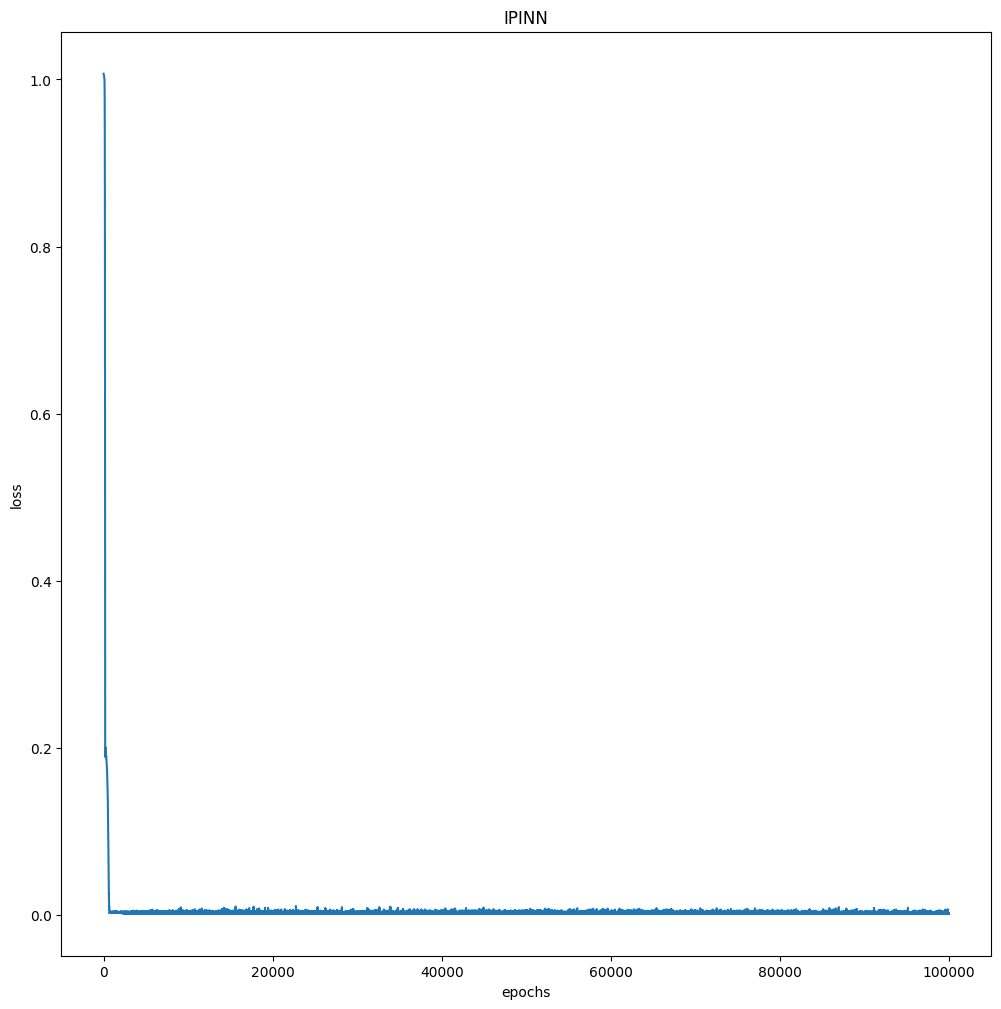

In [8]:
import pandas as pd
saved_loss = pd.DataFrame({'training loss': loss_hist, 'relative l2': relative_l2_hist})
saved_loss.to_csv('pinn_loss_hist.csv')
fig = plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), relative_l2_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('IPINN')

print(min(relative_l2_hist))